Quantization error: 6.43147357981779
Topographic error: 0.029


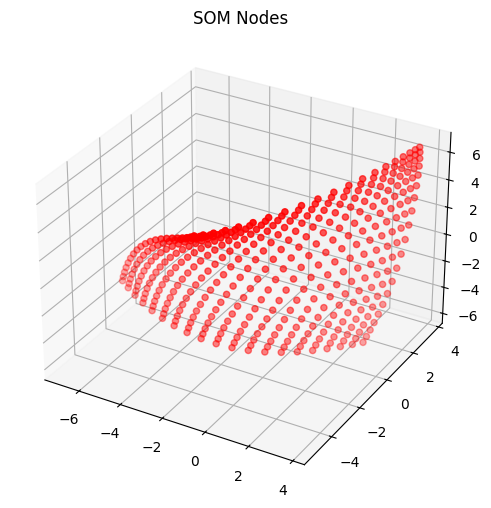

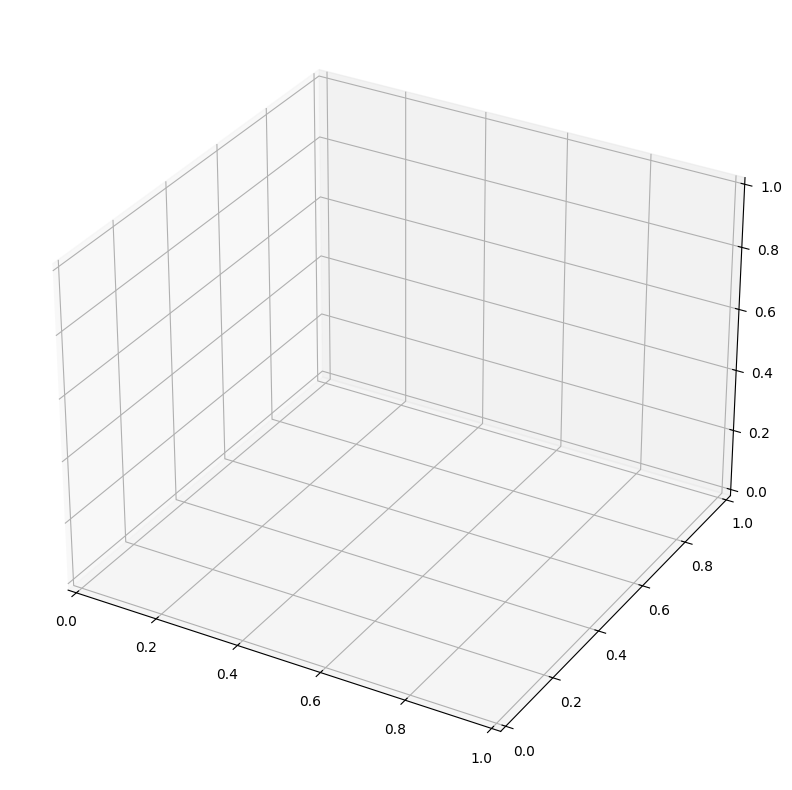

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.datasets import make_swiss_roll

class SOM:
    def __init__(self, data, N=20, topology="square", init="pca", seed=None): # initializes our SOM
        if seed is not None:
            np.random.seed(seed)

        self.data = np.asarray(data)
        self.N = N
        self.dim = self.data.shape[1]
        self.map_nodes = N * N
        self.topology = topology

        x, y = np.meshgrid(range(N), range(N))
        self.c = np.vstack([y.flatten(), x.flatten()]).T

        if init == "random":
            self.nodes = np.random.rand(self.map_nodes, self.dim)
        elif init == "pca":
            self.nodes = self._pca_init()

    def _pca_init(self):
        X = self.data - self.data.mean(axis=0)
        U, S, VT = svd(X, full_matrices=False)
        grid = self.c - self.c.mean(axis=0)
        W = grid @ VT[:2]
        return W

    def _bmu(self, x):
        return np.argmin(np.linalg.norm(self.nodes - x, axis=1))

    def _alpha(self, t, T):
        return 0.5 * np.exp(-t / T)

    def _sigma(self, t, T):
        return self.N * np.exp(-t / T)

    def train(self, epochs=2000):
        T = epochs
        for t in range(epochs):
            x = self.data[np.random.randint(len(self.data))]
            bmu = self._bmu(x)
            d = np.linalg.norm(self.c - self.c[bmu], axis=1)
            h = np.exp(-(d**2) / (2 * self._sigma(t, T)**2))
            self.nodes += self._alpha(t, T) * h[:, None] * (x - self.nodes)

    def quantization_error(self):
        return np.mean([
            np.linalg.norm(x - self.nodes[self._bmu(x)])
            for x in self.data
        ])

    def topographic_error(self):
        error = 0
        for x in self.data:
            d = np.linalg.norm(self.nodes - x, axis=1)
            bmu1, bmu2 = np.argsort(d)[:2]
            if np.linalg.norm(self.c[bmu1] - self.c[bmu2]) > 1:
                error += 1
        return error / len(self.data)

    def plot_nodes_3d(self):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(
            self.nodes[:, 0],
            self.nodes[:, 1],
            self.nodes[:, 2],
            c='red',
            s=20
        )
        ax.set_title("SOM Nodes")
        plt.show()

X, _ = make_swiss_roll(n_samples=2000)
X -= X.mean(axis=0)

som = SOM(X, N=20, init="pca")
som.train(epochs=3000)

print("Quantization error:", som.quantization_error())
print("Topographic error:", som.topographic_error())

som.plot_nodes_3d()

class MultimodalSOM:
    def __init__(self, modalities, N=20):
        self.modalities = modalities
        self.soms = {m: SOM(data, N=N) for m, data in modalities.items()}

# Initialize our SOM
#som_to_compare = SOM(dataset="nocolor_point_cloud", topoMap = "square", initMethod="random", N=10, size=10000, seed=None) # 20x20 grid

# Initial map
plt.show()

# Training
#som.train()
#indexList = [1,2,3,4,5,6,7,8,9,10]
#som.train_list(indexList)

# Final map
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plt.show()

# Visualization methods
#information = som.euclidian_comparison()
#for array in information:
#  print(array)


# Error calculations
#color_list = som.grader(5)
#nocolor_list = som_to_compare.grader(5)

#print("\nWith color init: ", color_list)
#print("Without color init: ", nocolor_list)
